### This notebook aims to numerically mimic the QPT process for a few-qubit-quantum-gate based on the qiskit simulator, where the realistic noise and error are taken into account.

Notes:  1.QPT for the one-qubit channel costs a few seconds on a laptop; less than 2 minutes for 2-q channel; more then ten hours for 3-q channel.
2. the initial states and rotations setup in QTP.py should be consistant with experiments (numerics ).


In [1]:
#====================some useful functions==========================

from QPT import QPT
from QPT import *
from numExp_qiskit import NumExp
from joblib import Parallel, delayed
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import itertools, random
from qutip import Qobj
from qutip.random_objects import rand_super_bcsz, rand_kraus_map, rand_unitary
from qiskit.quantum_info import random_unitary, Operator, average_gate_fidelity, Kraus, Chi, Choi
from scipy.linalg import sqrtm


def generate_valid_cptp_kraus_operators(n_qubits, num_kraus):
    """
    Generate a set of Kraus operators that satisfy the CPTP condition, ensuring ∑ K_i† K_i = I.

    Parameters:
    - n_qubits (int): Number of qubits
    - num_kraus (int): Number of Kraus operators to generate

    Returns:
    - list of numpy.ndarray: List of Kraus operators
    """
    # Define Pauli matrices for single qubits
    pauli = [qeye(2), sigmax(), sigmay(), sigmaz()]
    
    # Generate the tensor product of Pauli matrices for all possible combinations of qubits
    Elist = [tensor(*op).full() for op in itertools.product(pauli, repeat=n_qubits)]
    
    # Create Kraus operators by summing weighted Pauli matrices
    kraus_ops = [
        np.sum([(np.random.randn() + 1j * np.random.randn()) * E for E in Elist], axis=0)
        for _ in range(num_kraus)
    ]
    
    # Ensure the CPTP condition: ∑ K_i† K_i = I
    sum_kdag_k = sum(K.conj().T @ K for K in kraus_ops)
    sqrt_inv = np.linalg.inv(sqrtm(sum_kdag_k))
    
    # Normalize the Kraus operators to satisfy CPTP
    kraus_ops = [K @ sqrt_inv for K in kraus_ops]
    
    # Verify the CPTP condition again
    sum_kraus = sum(K.conj().T @ K for K in kraus_ops)
    
    if not np.allclose(sum_kraus, np.eye(2**n_qubits), rtol=1e-5):
        raise ValueError("The generated Kraus operators do not satisfy the CPTP condition!")
    
    # If only one Kraus operator is requested, generate a random unitary operator
    if num_kraus == 1:
        kraus_ops = [rand_unitary(2 ** n_qubits).full()]
    
    return kraus_ops

def get_chiF(chi1, chi2):
    """Calculate the fidelity between two quantum processes represented by χ matrices."""
    sqrt_chi1 = sqrtm(chi1)
    return np.real(np.trace(sqrtm(sqrt_chi1 @ chi2 @ sqrt_chi1))**2)


def get_exp_plot(measure_data,N):
  
    '''
    Visualizing the measurement data for a N-qubit gate (only for 1-q gate)
    '''

    if N<2:
        rotation = ["I", "ry(90)", 'rx(90)']
        initial_state =['|0>','|+>','|->','|1>']
        observables =['|0><0|','|1><1|']
        cir_lab = list(product(initial_state,rotation))
        
        z = measure_data  
        th = 0
        ylabel = []
        plt.figure()
        fig, ax = plt.subplots(figsize=(4,8))
        ax.imshow(z)
        ax.set_xticks(np.arange(len(observables)), labels=observables)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        for j in range(len(z)):
            for k in range(len(z[0])):
                text = ax.text(k,th, round(z[th,k], 3), ha="center", va="center", color="w")
            th+=1
            ylabel.append(cir_lab[j][0]+','+cir_lab[j][1])
        ax.set_yticks(np.arange(len(ylabel)), labels=ylabel)
        plt.show()
    else:
        print('It is only for N=1')
 



In [52]:
np.random.normal(loc=1, scale=0.2, size=1)[0]

1.0903657489734477

### The measurement data for a complete QPT of N-qubit quantum process

Example 1: the identity channel

In [2]:
"""
Parameters:
- N (int): Number of qubits
- p_reset (float): State preparation (SP) error
- p_meas (float): Measurement (M) error
- random_channel (list, optional): Random quantum channel
- num_kraus (int): the number of Kraus operator
"""

# Obtain the measurement data for a randomly sampled quantum channel
N, p_tot,num_kraus = 2, 0.000,1 
rdw = np.random.random(1)[0] # the weight coefficient
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)

# =========the numeric simulator===========#
Uid = np.identity(2 ** N)
# p_reset, p_meas, = 0.0,0
qiskit_sim = NumExp()
# An example: identity channel for illustration
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitay,[Uid] )

get_exp_plot(measure_data,N)

p_reset: 0.0 p_meas: 0.0 p_unitary: 0.0
It is only for N=1


### The standard QPT and EM-QPT

In [ ]:
p_tot,num_kraus = 0.0001,1# 
rdw = np.random.random(1)[0] # the weight coefficient for SPAM error
p_reset = p_tot * rdw
p_meas = p_tot* (1 - rdw)
p_unitay = p_tot
print('p_reset:', p_reset, 'p_meas:', p_meas,'p_unitary:', p_unitay)
random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)

# Define the Hilbert space dimension
ddim = [[2] * N, [2] * N]

# (1) the QPT experiments of identity
measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas, p_tot,[np.identity(2 ** N)])

# (2) the identity QPT
qiskit_sim = NumExp()
qptid = QPT(N, measure_data_id, random_channel)
chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)


# (3) the standard QPT 
measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_tot, random_channel)
qpt0 = QPT(N, measure_data, random_channel)
chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
chi_idea = qiskit_sim.get_idea_chi_matrix(random_channel, N)

# (4) the error-mitigated  QPT 
proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)

#rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]

chi_EM_a = qpt0.get_chi_LS_X(rho_in_noisy, qpt0.observables)
chi_EM_b = qpt0.get_chi_LS_X(qpt0.rho_in_idea, proj_noisy)
chi_EM_c = qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)

FF_noEM = get_chiF(chi_pred, chi_idea)
print(f"Fidelity (no EM): {FF_noEM}")

FF_EM_a =  get_chiF(chi_EM_a, chi_idea)
print(f"Fidelity (with EMa): {FF_EM_a}")

FF_EM_b = get_chiF(chi_EM_b, chi_idea)
print(f"Fidelity (with EMb): {FF_EM_b}")

FF_EM_c = get_chiF(chi_EM_c, chi_idea)
print(f"Fidelity (with EMc): {FF_EM_c}")


p_reset: 8.754122630162648e-05 p_meas: 1.2458773698373526e-05 p_unitary: 0.0001
Fidelity (no EM): 0.991511480689556
Fidelity (with EMa): 0
Fidelity (with EMb): 0
Fidelity (with EMc): 0.2622862481549507


-0.041411274329612294

In [ ]:
#### 这是为了画图收集数据
def get_result(N,p_tot,p_unitary,num_kraus):
    num_kraus =  1#np.random.randint(0,2**(2*N)+1)+1#1#
    #p_tot,num_kraus = 0.0,1 # 
    rdw = 0.5#np.random.random(1)[0] # the weight coefficient for SPAM error
    p_reset = p_tot * rdw
    p_meas = p_tot* (1 - rdw)
    #print('p_reset:', p_reset, 'p_meas:', p_meas)
    random_channel = generate_valid_cptp_kraus_operators(n_qubits=N, num_kraus=num_kraus)
    qiskit_sim = NumExp()
    # (1) the QPT experiments of identity
    measure_data_id = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitary, [np.identity(2 ** N)])
    # (2) the identity QPT
    qptid = QPT(N, measure_data_id, random_channel)
    chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)
    # (3) the standard QPT 
    measure_data = qiskit_sim.get_measurement(N, p_reset, p_meas,p_unitary, random_channel)
    qpt0 = QPT(N, measure_data, random_channel)
    chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
    chi_idea = qiskit_sim.get_idea_chi_matrix(random_channel, N)
    # (4) the error-mitigated  QPT 
    proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
    rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)
    #rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]

    chi_EM_a = qpt0.get_chi_LS_X(rho_in_noisy, qpt0.observables)
    chi_EM_b = []#qpt0.get_chi_LS_X(qpt0.rho_in_idea, proj_noisy)
    chi_EM_c = []#qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)
    return chi_idea,chi_pred,chi_EM_a,chi_EM_b,chi_EM_c

def get_resultn(N,p_tot,p_unitary,num_kraus):
    FF_noEMlist,FF_EM_alist,FF_EM_blist,FF_EM_clist =[],[],[],[]
    for i in range(10):
        chi_idea,chi_pred,chi_EM_a,chi_EM_b,chi_EM_c = get_result(N,p_tot,p_unitary,num_kraus)
        FF_noEM = get_chiF(chi_pred, chi_idea);FF_noEMlist.append(FF_noEM)
        FF_EM_a = 0#get_chiF(chi_EM_a, chi_idea);
        FF_EM_alist.append(FF_EM_a)
        FF_EM_b = 0#get_chiF(chi_EM_b, chi_idea);
        FF_EM_blist.append(FF_EM_b)
        FF_EM_c = get_chiF(chi_EM_c, chi_idea);FF_EM_clist.append(FF_EM_c)
    return [FF_noEMlist,FF_EM_alist,FF_EM_blist,FF_EM_clist]#

plist = np.linspace(0,0.2,15)
plist1 = np.linspace(0,0.4,15)
#num_kraus_list = [1]#np.arange(2**(2*N))
N = 2
F_cell = []
#for p in plist:
F_cell_p = Parallel(n_jobs=10, verbose=5)(delayed(get_resultn)(N,p_tot,p_u,num_kraus) for p_tot in plist for p_u in plist1)

#F_cell.append(F_cell_p)
#np.savez('./F_cell_'+str(N)+'q'+''+str(num_kraus)+'_kraus.npz',F_cell_p=F_cell_p,plist=plist)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
Exception ignored in: <function _xla_gc_callback at 0x13bcc7600>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/forQPT/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
#np.savez('./F_cell_2d_'+str(N)+'q'+'_rand_kraus.npz',F_cell_p=F_cell_p,p_tot=plist,p_u=plist1)

Text(0.5, 0, 'incoherent error')

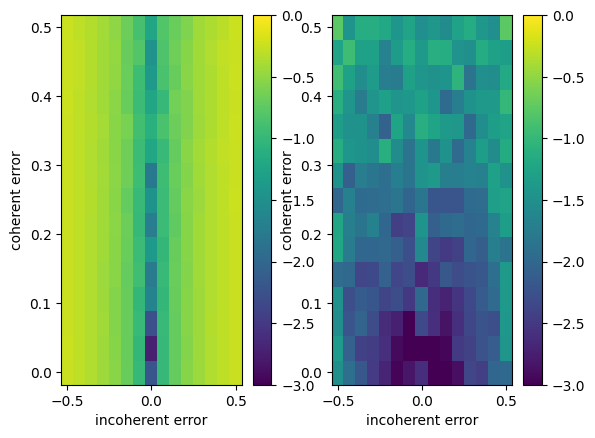

In [7]:
lenth = 15*15
F_cell_p1 =np.log10(1-np.array(F_cell_p))
F_cell_noEM = np.array([np.average(F_cell_p1[i,0,:]) for i in range(lenth)]).reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
F_cell_EMc = np.array([np.average(F_cell_p1[i,3,:]) for i in range(lenth)]).reshape(int(np.sqrt(lenth)),int(np.sqrt(lenth)))
#F_cell_noEM,F_cell_EMc = np.log10(1-F_cell_noEM),np.log10(1-F_cell_EMc)
vi,vx = -3,0
plt.subplot(1,2,1)
plt.pcolor(plist ,plist1,F_cell_noEM.T,vmin=vi,vmax=vx)
plt.colorbar()
plt.ylabel('coherent error')
plt.xlabel('incoherent error')
plt.subplot(1,2,2)
plt.pcolor(plist ,plist1,F_cell_EMc.T,vmin=vi,vmax=vx)
plt.colorbar()
plt.ylabel('coherent error')
plt.xlabel('incoherent error')

In [ ]:
#np.savez('./F_cell_'+str(N)+'q_randkraus.npz',F_cell_p=F_cell_p,plist=plist)

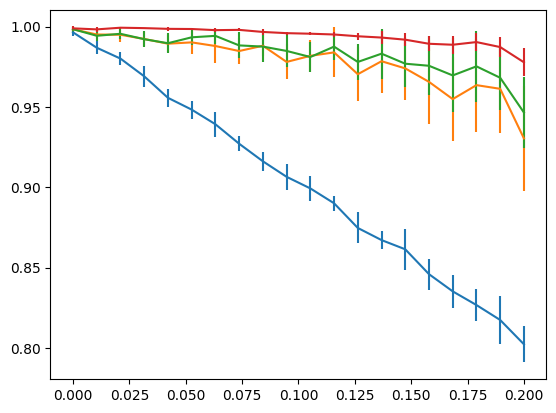

In [84]:
F_cell_p = np.array(F_cell_p)
iF_cell_p = F_cell_p##np.log10(1-F_cell_p)
for i in range(4):
    F_list = np.array([np.average(FF[i,:]) for FF in iF_cell_p])
    F_list_std = np.array([np.std(FF[i,:]) for FF in iF_cell_p])
    plt.errorbar(plist,y = F_list,yerr = F_list_std)
#plt.ylim([-5,-1])

array([0.99709394, 0.9958677 , 0.9945302 , 0.9896026 , 0.99139755,
       0.98891652, 0.98282854, 0.97620912, 0.97800247, 0.9756146 ])

### Plot the Chi matrix and revised probes

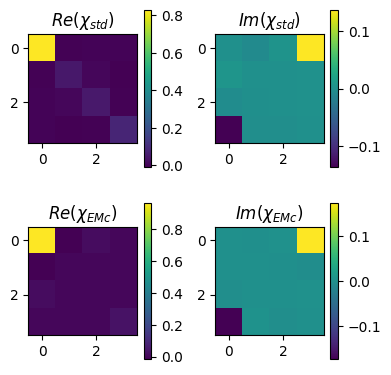

In [19]:
# the \chi matrix
zlist =[np.real(chi_pred),np.imag(chi_pred),np.real(chi_EM_c),np.imag(chi_EM_c)]
titlist = [r'$Re(\chi_{std})$',r'$Im(\chi_{std})$',r'$Re(\chi_{EMc})$',r'$Im(\chi_{EMc})$']

plt.figure(figsize=(4,4))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(zlist[i])
    plt.colorbar()
    plt.title(titlist[i])
plt.tight_layout()



Text(0, 0.5, '$F(\\rho_{i},\\bar{\\rho_i})$')

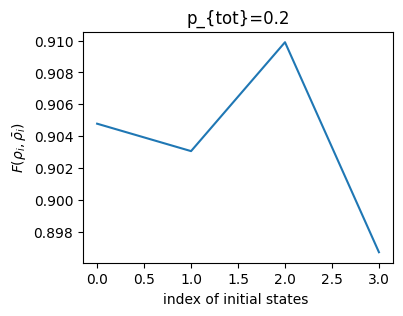

In [20]:
# the fidelty between the ideal and revised input states for a given error rate 
Flist = [get_chiF(rho_in_noisy[i].full(),qpt0.rho_in_idea[i].full()) for i in range(len(rho_in_noisy))]
plt.figure(figsize=(4,3))
plt.plot(Flist)
plt.title('p_{tot}='+str(p_tot))
plt.xlabel('index of initial states ')
plt.ylabel(r'$F(\rho_{i},\bar{\rho_i})$')

### loading the experimental data

In [6]:
'''
======== Noting the dataform is required to fit the setup in QPT, as illustrated in numerical simulator========
#### the example is the 1q gate
'''
N = 1
gate_num = 24
from copy import deepcopy

# loading the experimental data#QPT data unitary sweep 31032025 d46584
network_location ='./exp_data/QPT data full clifford 01042025/'#'./exp_data/QPT data threshhold and unitary sweep d46589/'#'./exp_data/QPT with 30 percent threshhold correction/'
#'./exp_data/QPT data 40 percent threshhold/'#"./exp_data/QPT with different threshhold I/" #"./exp_data/QPT data 30032025/"
name1 ='d46593_2025_04_01_16_07_13_QPT_clifford_RB_loop_with_noise'#'d46589_2025_03_31_19_08_15_QPT_RB_loop_with_noise'#'d46584_2025_03_31_17_57_00_QPT_RB_loop_with_noise'#'d46570_2025_03_28_19_26_08_QPT_RB_loop'#
#'d46574_2025_03_30_17_29_13_QPT_RB_loop'#'d46576_2025_03_31_10_33_32_QPT_RB_loop'# 'd46573_2025_03_30_15_24_43_QPT_RB_loop'#'d46570_2025_03_28_19_26_08_QPT_RB_loop'
#twpadat = scipy.io.loadmat('./VAE/1q_Aalto/test data/d46558_2025_03_28_17_34_35_QPT_RB_loop.mat')
twpadat = scipy.io.loadmat(network_location +name1 +'.mat')
#print(twpadat)

Nrep = deepcopy(twpadat['Nrep'][0][0])
N_QPT_rep = deepcopy(twpadat['N_QPT_rep'][0][0])
num_levels = deepcopy(twpadat['num_levels'][0][0])
max_circuit_depth = deepcopy(twpadat['max_circuit_depth'][0][0])
delta_clifford = deepcopy(twpadat['delta_clifford'][0][0])
#RB data
rb_value_data =  np.memmap(network_location +name1 + '_rb_value_data.dat', dtype = 'float', mode='r', shape=(Nrep,int(max_circuit_depth / delta_clifford),4))
rb_fit_data = np.memmap(network_location +name1 + '_rb_fit_data.dat', dtype = 'float', mode='r', shape=(Nrep,5,5))#shape=(Nrep,5,5)# the new 5 gate data

#QPT data
qpt_avg_data = np.memmap(network_location +name1 + '_qpt_data.dat', dtype = 'float', mode='r', shape=(Nrep, N_QPT_rep, num_levels, gate_num, 4, 3))
qpt_single_shot_data = np.memmap(network_location +name1 + '_qpt_sshot_data.dat', dtype = 'float', mode='r', shape=(Nrep,N_QPT_rep, gate_num, 4, 3, 4))
qpt_cal_I_data = np.memmap(network_location +name1 +'_qpt_cal_I.dat', dtype = 'float', mode='r', shape=(Nrep,N_QPT_rep, 3))
qpt_cal_Q_data = np.memmap(network_location +name1 + '_qpt_cal_Q.dat', dtype = 'float', mode='r', shape=(Nrep,N_QPT_rep, 3))
qpt_single_shot_data_new = np.einsum('ijklmn->ijnklm',qpt_single_shot_data)


def reshape_expdata(data_I):
    exp_data_I =np.zeros(shape=(12,2)) 
    th = 0
    for i in range(4):
        for j in range(3):
            exp_data_I[th,:2]=data_I[:2,i,j]/np.sum(data_I[:2,i,j])
            th+=1
    return exp_data_I


data_I = reshape_expdata(qpt_avg_data[0,0,:,0,:,:]) # observable, gate,state pre,rotation,
data_rx90 = reshape_expdata(qpt_avg_data[0,0,:,1,:,:])
data_ry90 = reshape_expdata(qpt_avg_data[0,0,:,2,:,:])
data_X = reshape_expdata(qpt_avg_data[0,0,:,3,:,:])

 
print(np.shape(qpt_avg_data))

(1, 10, 3, 24, 4, 3)


In [15]:
qpt_avg_data[0,0,:,0,0,0]

array([0.8947, 0.0417, 0.0636])

In [6]:
np.shape(qpt_avg_data_new)

(42, 25, 3, 4, 4, 3)

In [7]:

# network_location = "D:\\MeasurementData/2025/03/30/"

QPT_RB_data = twpadat#scipy.io.loadmat(network_location +'d46574_2025_03_30_17_29_13_QPT_RB_loop.mat')


Nrep = deepcopy(QPT_RB_data['Nrep'][0][0])
N_QPT_rep = deepcopy(QPT_RB_data['N_QPT_rep'][0][0])
num_levels = deepcopy(QPT_RB_data['num_levels'][0][0])
max_circuit_depth = deepcopy(QPT_RB_data['max_circuit_depth'][0][0])
delta_clifford = deepcopy(QPT_RB_data['delta_clifford'][0][0])
n_avg_qpt = deepcopy(QPT_RB_data['n_avg_qpt'][0][0])

Mconf = deepcopy(QPT_RB_data['Mconf'])


qpt_avg_data_new = qpt_avg_data# #np.zeros(shape=np.shape(qpt_avg_data))#
# qpt_avg_data_new[:,:,:2,:,:]=qpt_single_shot_data_new[:,:,:2,:,:]
# qpt_avg_data_new[:,:,2,:,:]=qpt_single_shot_data_new[:,:,2,:,:]+qpt_single_shot_data_new[:,:,3,:,:]
# qpt_avg_data_new = np.einsum('ijklmn,ko->ijolmn',qpt_avg_data_new,np.linalg.inv(Mconf.T).T)


Igref = deepcopy(QPT_RB_data['Igref'][0][0])
Qgref = deepcopy(QPT_RB_data['Qgref'][0][0])

Ieref = deepcopy(QPT_RB_data['Ieref'][0][0])
Qeref = deepcopy(QPT_RB_data['Qeref'][0][0])

Ifref = deepcopy(QPT_RB_data['Ifref'][0][0])
Qfref = deepcopy(QPT_RB_data['Qfref'][0][0])

Ithresh = (Igref+Ieref)/2
Qthresh = (Qeref+Qfref)/2

n_avg_qpt = 1000
qpt_all_I_data = np.memmap(network_location +name1 +'_qpt_allI.dat', dtype = 'float', mode='r',shape=(Nrep,N_QPT_rep,n_avg_qpt,4,4,3))
qpt_all_Q_data = np.memmap(network_location +name1 + '_qpt_allQ.dat', dtype = 'float', mode='r',shape=(Nrep,N_QPT_rep,n_avg_qpt,4,4,3) )


print(np.shape(qpt_all_I_data ))
Ithresh = (Igref+Ieref)/2
Qthresh = (Qeref+Qfref)/2

mask_g = np.logical_and(qpt_all_Q_data<Qthresh, qpt_all_I_data>Ithresh)
mask_e = np.logical_and(qpt_all_Q_data<Qthresh, qpt_all_I_data<Ithresh)
mask_f = qpt_all_Q_data>Qthresh

post_process_qpt = np.zeros(qpt_avg_data.shape)
post_process_qpt[:,:,0,:,:,:] = mask_g.sum(axis=2)/qpt_all_I_data.shape[2]
post_process_qpt[:,:,1,:,:,:] = mask_e.sum(axis=2)/qpt_all_I_data.shape[2]
post_process_qpt[:,:,2,:,:,:] = mask_f.sum(axis=2)/qpt_all_I_data.shape[2]

x = qpt_all_I_data[0,0,:,0,0,0]#[mask_g]#mask_g['']#post_process_qpt[mask_g]#qpt_all_I_data[0,0,:,0,0,0]
y = qpt_all_Q_data[0,0,:,0,0,0]#[mask_g]#qpt_all_Q_data[0,0,:,0,0,0]
plt.scatter(x,y,s=5)
x = qpt_all_I_data[0,0,:,-1,0,0]#[mask_g]#mask_g['']#post_process_qpt[mask_g]#qpt_all_I_data[0,0,:,0,0,0]
y = qpt_all_Q_data[0,0,:,-1,0,0]#[mask_g]#qpt_all_Q_data[0,0,:,0,0,0]
plt.scatter(x,y,s=5)
plt.vlines(x=Ithresh,ymax=0.015,ymin=-0.015)
plt.hlines(y=Qthresh,xmax=0.025,xmin=0.0)
# x = qpt_all_I_data[0,0,:,0,0,0]#[mask_g]#mask_g['']#post_process_qpt[mask_g]#qpt_all_I_data[0,0,:,0,0,0]
# y = qpt_all_Q_data[0,0,:,0,0,0]#[mask_g]#qpt_all_Q_data[0,0,:,0,0,0]
# plt.scatter(x,y,s=5)
# x = qpt_all_I_data[0,0,:,0,1,0]
# y = qpt_all_Q_data[0,0,:,0,1,0]
# plt.scatter(x,y,s=5)
# x = qpt_raw_I_data[0,0,:,0,0,2]
# y = qpt_raw_Q_data[0,0,:,0,0,2]
# plt.scatter(x,y,s=5)

(1, 10, 1000, 4, 4, 3)


ValueError: could not broadcast input array from shape (1,10,4,4,3) into shape (1,10,24,4,3)

In [44]:
np.shape(qpt_all_I_data)

(11, 10, 1000, 4, 4, 3)

In [11]:
# rep_id=-1
# qpt_id = -1

# pop = qpt_avg_data[rep_id,qpt_id,:,:,:,:]
# pop_singlesot = qpt_single_shot_data_new[rep_id,qpt_id,:,:,:,:]
# plt.figure(figsize=(15,15))

# count = 1
# x_plot = ['I', 'X90', 'Y90', 'X180']
# for l in range(pop.shape[2]):
#     for m in range(pop.shape[3]):
#         plt.subplot(pop.shape[2], pop.shape[3], count)
#         count += 1
#         for k in range(3):
#             plt.plot(x_plot, pop[k, :, l, m], label=f"{k}")
#             plt.plot(x_plot, pop_singlesot[k, :, l, m], color='k', label=f"{k}")
            
#             if (l == 0) & (m == 0):
#                 plt.ylabel('State pop with Init(g)')
#             if (l == 1) & (m == 0):
#                 plt.ylabel('State pop with X90')
#             if (l == 2) & (m == 0):
#                 plt.ylabel('State pop with Y90')
#             if (l == 3) & (m == 0):
#                 plt.ylabel('State pop with X180')
#             if (l == 0) & (m == 0):
#                 plt.title('Z projection')
#             if (l == 0) & (m == 1):
#                 plt.title('X projection')
#             if (l == 0) & (m == 2):
#                 plt.title('Y projection')
#         plt.plot(x_plot, pop_singlesot[3,:, l, m], color='m', label=f"{k}")
#         plt.legend()
                            


In [4]:
np.shape(rb_fit_data)

(42, 5, 5)

In [8]:
# rb data
fid_rb_cell=[]
for rep_id in range(1):
    fidlist=[]
    for indx in range(5):
        one_minus_p, r_c, r_g, r_c_std, r_g_std = rb_fit_data[rep_id,:,indx]
        if indx==0:
            r_c_ref = r_c
        fid = 1-(r_c-r_c_ref)/4#np.format_float_scientific(1-(r_c-r_c_ref)/4, precision=6)
        fidlist.append(fid)
    fid_rb_cell.append([fidlist])
fid_rb_cell = np.array(fid_rb_cell)
print(np.shape(fid_rb_cell))

(1, 1, 5)


<Figure size 640x480 with 0 Axes>

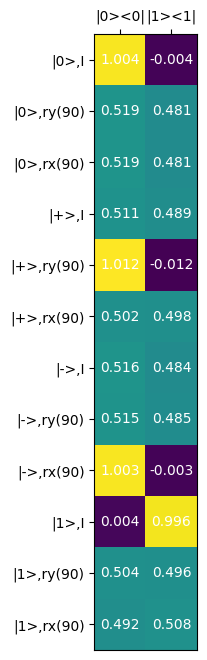

In [23]:
# an example for the identity data

get_exp_plot(data_I,N)

In [9]:
from qutip.qip.operations.gates import rx,ry
cases = [
    ["I" ],  
    ["X180" ],  
    ["Y180" ],  
    ["Y180", "X180"], 
    ["X90", "Y90"], 
    ["X90", "-Y90"], 
    ["-X90", "Y90"],  
    ["-X90", "-Y90"],  
    ["Y90", "X90"], 
    ["Y90", "-X90"],  
    ["-Y90", "X90"],  
    ["-Y90", "-X90"],  
    ["X90" ], 
    ["-X90" ], 
    ["Y90" ],  
    ["-Y90" ],  
    ["-X90", "Y90", "X90"],   
    ["-X90", "-Y90", "X90"],  
    ["X180", "Y90"], 
    ["X180", "-Y90"], 
    ["Y180", "X90"],  
    ["Y180", "-X90"],  
    ["X90", "Y90", "X90"],   
    ["-X90", "Y90", "-X90"]  
]
quantum_gates = {
    "I":qeye(2),
    "X90": rx(np.pi / 2),
    "-X90": rx(-np.pi / 2),
    "Y90": ry(np.pi / 2),
    "-Y90": ry(-np.pi / 2),
    "X180": rx(np.pi),
    "Y180": ry(np.pi)
}
ideal_gate_clif = []
for ca in cases:
    g0 = qeye(2)
    for g in ca:
        g0= quantum_gates[g]*g0
    ideal_gate_clif.append(g0)
# print(ideal_gate_clif)

In [21]:
g

'I'

In [18]:
42*25

1050

In [ ]:
def get_average(chi1,chi2):
    return (get_chiF(chi1, chi2)*(2**N)+1)/(2**N+1)  # /np.sqrt(np.trace(chi1.conj().T@chi1)*np.trace(chi2.conj().T@chi2))


def EM_QPT(idea_channel,measure_data_gate,measure_data_id):

    random_channel = [idea_channel]
    # (2) the identity QPT
    qptid = QPT(N, measure_data_id, [np.identity(2 ** N)])
    chi_id_pred = qptid.get_chi_LS_X(qptid.rho_in_idea, qptid.observables)

    qiskit_sim = NumExp()
    # (3) the standard QPT 
    qpt0 = QPT(N, measure_data_gate, random_channel)
    chi_pred = qpt0.get_chi_LS_X(qpt0.rho_in_idea, qpt0.observables) 
    chi_idea = qiskit_sim.get_idea_chi_matrix(random_channel, N)
    #print(Qobj(chi_pred),Qobj(chi_idea))
    # (4) the error-mitigated  QPT 
    proj_noisy = qpt0.get_noisy_proj_1(chi_id_pred)
    rho_in_noisy = qpt0.get_noisy_state(chi_id_pred)

    #rho_out_idea = [Qobj(np.sum([K @ rho.full() @ K.conj().T for K in random_channel], axis=0),dims=ddim,) for rho in qpt0.rho_in_idea]

    chi_EM_a = qpt0.get_chi_LS_X(rho_in_noisy, qpt0.observables)
    chi_EM_b = qpt0.get_chi_LS_X(qpt0.rho_in_idea, proj_noisy)
    chi_EM_c = qpt0.get_chi_LS_X(rho_in_noisy, proj_noisy)

    FF_noEM = get_average(chi_pred, chi_idea)
    #print(f"Fidelity (no EM): {FF_noEM}")

    FF_EM_a = get_average(chi_EM_a, chi_idea)
    #print(f"Fidelity (with EMa): {FF_EM_a}")

    FF_EM_b = get_average(chi_EM_b, chi_idea)
    #print(f"Fidelity (with EMb): {FF_EM_b}")

    FF_EM_c = get_average(chi_EM_c, chi_idea)
    #print(f"Fidelity (with EMc): {FF_EM_c}")
    return FF_noEM,FF_EM_a,FF_EM_b,FF_EM_c


ideal_gate_list =[qeye(2),qugate.rx(np.pi/2 ).full(),qugate.ry(np.pi/2 ).full(),qugate.rx(np.pi).full()]
gate_str =['I','RX90','Ry90','X']
if gate_num==24:
    ideal_gate_list = ideal_gate_clif
else:
    ideal_gate_list =ideal_gate_list
qpt_avg_data = qpt_avg_data_new
F_cell = []
for kk in range(1):
    print(kk)
    for jj in range(10):
        measure_list =[reshape_expdata(qpt_avg_data[kk,jj,:,i,:,:]) for i in range(gate_num)]
        # data_I = reshape_expdata(qpt_avg_data[kk,jj,:,0,:,:]) # observable, gate,state pre,rotation,
        # data_rx90 = reshape_expdata(qpt_avg_data[kk,jj,:,1,:,:])
        # data_ry90 = reshape_expdata(qpt_avg_data[kk,jj,:,2,:,:])
        # data_X = reshape_expdata(qpt_avg_data[kk,jj,:,3,:,:])
        # measure_list =[data_I,data_rx90,data_ry90,data_X]
        Flist =[]
        for i in range(24):
            #print('QPT for ('+gate_str[i]+') gate')
            measure_data_id = data_I[:,:2]
            idea_channel = ideal_gate_list[i][:,:2]
            measure_data_gate = measure_list[i][:,:2]
            FF_noEM,FF_EM_a,FF_EM_b,FF_EM_c =EM_QPT(idea_channel,measure_data_gate,measure_data_id)
            Flist.append([FF_noEM,FF_EM_a,FF_EM_b,FF_EM_c])
        #Flist= np.array(Flist)
        #F_ave = [np.average(Flist[i,0]) for i in range(4) ]
        F_cell.append(Flist)


0


KeyboardInterrupt: 

In [34]:
FF = np.reshape(F_cell,(240,4))
print(np.average(FF[:,0]),np.average(FF[:,-1]))

0.9881775520131696 0.9948095663679286


In [36]:
np.average(fid_rb_cell[:,:,1:])

0.9998581162136734

In [21]:
print(np.shape(F_cell))
F_cell = np.array(F_cell)
F_cell1 = F_cell.reshape(42,25,4,4)

(1050, 4, 4)


In [132]:
print(np.shape(F_cell1))
Fnew = F_cell1.reshape(6,7,25,4,4)
Fnew0,Fnew1 = np.average(Fnew[:,:,:,1,0],axis=-1),np.average(Fnew[:,:,:,1,-1],axis=-1)
#Fnew0,Fnew1 = np.std(Fnew[:,:,:,2,0],axis=-1),np.std(Fnew[:,:,:,2,-1],axis=-1)
x= np.linspace(0.2,0.8,7)
y = np.linspace(0,0.5,6)
X,Y = np.meshgrid(x,y)
print(X,Y)
print(np.shape(X),np.shape(Fnew0))

(42, 25, 4, 4)
[[0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8]
 [0.2 0.3 0.4 0.5 0.6 0.7 0.8]] [[0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.2 0.2 0.2 0.2 0.2 0.2 0.2]
 [0.3 0.3 0.3 0.3 0.3 0.3 0.3]
 [0.4 0.4 0.4 0.4 0.4 0.4 0.4]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
(6, 7) (6, 7)


In [37]:
Fnew0[:,4]

array([0.99174072, 0.99276389, 0.99006706, 0.98385129, 0.97509918,
       0.96598175])

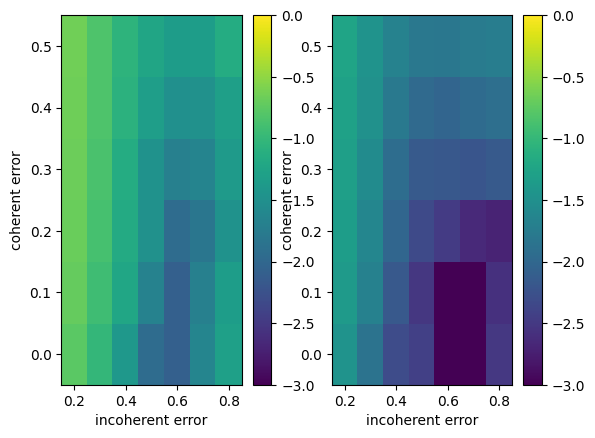

In [133]:
vi,vx = -3,0
plt.figure()
plt.subplot(1,2,1)
plt.pcolor(X,Y,np.log10(1-Fnew0),vmin=vi,vmax=vx)
plt.ylabel('coherent error')
plt.xlabel('incoherent error')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(X,Y,np.log10(1-Fnew1),vmin=vi,vmax=vx)
plt.ylabel('coherent error')
plt.xlabel('incoherent error')
plt.colorbar()

In [ ]:
# np.savez('F_2d_error.npz',Fnew=Fnew,x=x,y=y)

/var/folders/gt/wsynvnn526b468b8m4bq36g00000gn/T/ipykernel_88057/1217204664.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x,np.log10(1-fid_rb_cell[:,0,j]),label='RB',color='r',s=15)


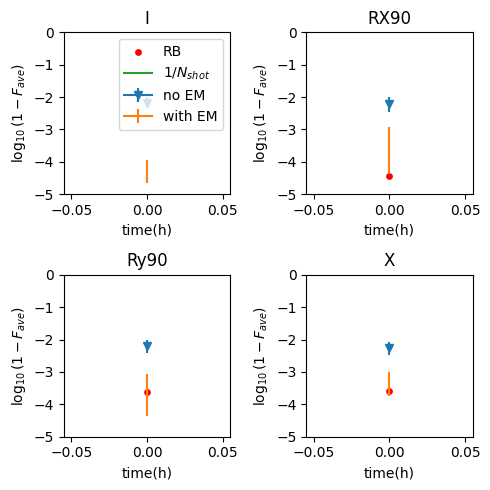

In [ ]:
F_cell1=np.array(F_cell).reshape(1,100,1,4,4)
plt.figure(figsize=(5,5))

for j in range(1):
    plt.subplot(2,2,j+1)
    plt.title(gate_str[j])
    Flist0,Flist1 =[],[]
    for i in range(1):
        F_ave_noEM0 = np.average(np.log10(1-F_cell1[i,:,:,j,0]))
        F_std_noEM0 = np.std(np.log10(1-F_cell1[i,:,:,j,0]))
        F_ave_noEMc = np.average(np.log10(1-F_cell1[i,:,:,j,-1]))
        F_std_noEMc = np.std(np.log10(1-F_cell1[i,:,:,j,-1]))
        Flist0.append([F_ave_noEM0,F_std_noEM0])
        Flist1.append([F_ave_noEMc,F_std_noEMc ])
    Flist0,Flist1 = np.array(Flist0),np.array(Flist1)
    
    x = np.linspace(0,36,1)
    plt.errorbar(x,y=Flist0[:,0],yerr=Flist0[:,1],label='no EM',ms=6,fmt='-v')
    plt.errorbar(x,y=Flist1[:,0],yerr=Flist1[:,1],label='with EM')
    plt.scatter(x,np.log10(1-fid_rb_cell[:,0,j]),label='RB',color='r',s=15)
    plt.plot(x,np.log10(np.ones(len(x))*(1/1000)),label=r'$1/N_{shot}$')
    if j ==0:
        plt.legend()
    plt.ylim([-5,0])
    plt.xlabel('time(h)')
    plt.ylabel(r'$\log_{10}(1-F_{ave})$')
plt.tight_layout()

0
1


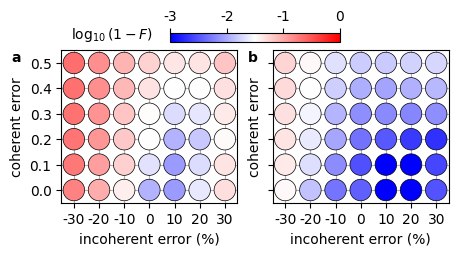

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler

data = np.load('F_2d_error.npz')
Fnew =data['Fnew']#[:,:5,:,:,:]
x,y = data['x'],data['y']
Xlist, Ylist,Clist,S_norm_list,Sstd_list=[],[],[],[],[]
#Fnew = np.log10(1-Fnew)
x= np.linspace(0.2,0.8,7)#[:5]
y = np.linspace(0,0.5,6)
ind=[0,-1]
for i in range(2):
    
    Fnew0  = np.average(Fnew[:,:,:,1,ind[i]],axis=-1) 
    Fnew0 = np.log10(1-Fnew0)
    Fnew0_std  = np.std(Fnew[:,:,:,2,ind[i]],axis=-1) 
    #Fnew0_std = np.log10(1-Fnew0_std)
    

    X0,Y0 = np.meshgrid(x,y)
    X, Y = X0.flatten(), Y0.flatten()  # 转换为1D数组0
    # 生成数据
    C = Fnew0  # 颜色深浅代表的量
    S = Fnew0_std#/ Fnew0# 大小代表的量
    vmin, vmax = -3, 0  # 你可以根据需求调整这个范围
    norm_C = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 归一化大小 (映射到合适的像素范围，比如 50 到 500)
    scaler = MinMaxScaler(feature_range=(50, 500))
    S_norm = scaler.fit_transform(S.reshape(-1, 1)).flatten()

    Xlist.append(X) 
    Ylist.append(Y)
    Clist.append(C)
    S_norm_list.append(S_norm)
    Sstd_list.append(S)

# 创建绘图
fig, axes = plt.subplots(1, 2, figsize=(5, 2.2), sharex=True, sharey=True)
# 遍历子图绘制相同的散点图
for i, ax in enumerate(axes):
    print(i)
    X,Y,C,S_norm = Xlist[i], Ylist[i],Clist[i],S_norm_list[i]
    # 绘制散点图
    S_norm = np.ones(shape=np.shape(S_norm))*240
    ax.grid(zorder=1)
    sc = ax.scatter(X, Y, c=C, s=S_norm, cmap='bwr', norm=norm_C, edgecolors='black', alpha=1,zorder=2,lw=0.5)
    
    # # 在每个点内写上对应大小的数值
    # for i in range(len(y)):
    #     for j in range(len(x)):
    #         text = ax.text(x[j], y[i], str(np.round(C[i, j],1)),
    #                     ha="center", va="center", color="k",fontweight='ultralight')#r'$10^{'+str(np.round(np.log10(S[i, j]),1))+'}$',
    
    # 设置标题
    ax.set_xticks(x,['-30','-20','-10','0','10','20','30'])#,[' ',' ',' ',' ',' ',' ',' ']
    ax.set_yticks(y)
    ax.set_xlim([0.15,0.85])
    ax.set_ylim([-0.05,0.55])
    ax.set_xlabel('incoherent error (%)')
    ax.set_ylabel('coherent error')
    if i ==0:
        ax.text(0.35, 0.61,r'$\log_{10}(1-F)$',ha="center", va="center", color="k")
        ax.text(-0.03, 0.52,'a',ha="center", va="center", color="k",fontweight='demi')
    else:
        ax.text(0.07, 0.52,'b',ha="center", va="center", color="k",fontweight='demi')
# 添加共享的颜色条

cbar = fig.colorbar(sc, ax=axes, location='top', fraction=0.05, pad=0.05)#vertical horizontal orientation="horizontal",
#cbar.set_label("infidelity")
cbar.set_ticks(np.linspace(vmin, vmax, 5))  # 颜色条刻度
cbar.set_ticks([-3, -2, -1,0])  # 设置刻度位置
cbar.set_ticklabels(['-3', '-2', '-1','0'])  # 设置刻度标签
plt.show()



0
1


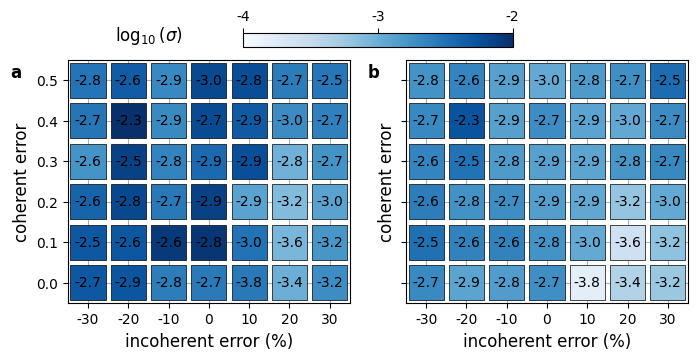

In [201]:
FS = 12
# 创建绘图
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharex=True, sharey=True)
# 遍历子图绘制相同的散点图
for th, ax in enumerate(axes):
    print(th)
    X,Y,C,S_norm,Sstd= Xlist[th], Ylist[th],Clist[th],S_norm_list[th],Sstd_list[th]
    # 绘制散点图
    S_norm = np.ones(shape=np.shape(S_norm))*640
    
    vmin, vmax = -4,-2  # 你可以根据需求调整这个范围
    norm_C = mcolors.Normalize(vmin=vmin, vmax=vmax)

    ax.grid(zorder=1)
    sc = ax.scatter(X, Y, c=np.log10(Sstd), s=S_norm, cmap='Blues', marker='s',norm=norm_C, edgecolors='black', alpha=1,zorder=2,lw=0.5)
    
    # # 在每个点内写上对应大小的数值
    for i in range(len(y)):
        for j in range(len(x)):
            text = ax.text(x[j], y[i], str(np.round(np.log10(S[i, j]),1)),
                        ha="center", va="center", color="k")#r'$10^{'+str(np.round(np.log10(S[i, j]),1))+'}$',
    # 设置标题
    ax.set_xticks(x,['-30','-20','-10','0','10','20','30'])#,[' ',' ',' ',' ',' ',' ',' ']
    ax.set_yticks(y)
    ax.set_xlim([0.15,0.85])
    ax.set_ylim([-0.05,0.55])
    ax.set_xlabel('incoherent error (%)',fontsize=FS)
    ax.set_ylabel('coherent error',fontsize=FS)
    if th ==0:
        ax.text(0.35, 0.61,r'$\log_{10}(\sigma)$',ha="center", va="center", color="k",fontsize=FS)
        ax.text(0.02, 0.52,'a',ha="center", va="center", color="k",fontweight='demi',fontsize=FS)
    else:
        ax.text(0.07, 0.52,'b',ha="center", va="center", color="k",fontweight='demi',fontsize=FS)
# 添加共享的颜色条

cbar = fig.colorbar(sc, ax=axes, location='top', fraction=0.05, pad=0.05)#vertical horizontal orientation="horizontal",
#cbar.set_label("infidelity")
cbar.set_ticks(np.linspace(vmin, vmax, 5))  # 颜色条刻度
cbar.set_ticks([-4,-3, -2 ])  # 设置刻度位置
cbar.set_ticklabels(['-4','-3', '-2' ])  # 设置刻度标签
plt.show()


In [144]:
10**np.round(np.log10(1-S[i, j]),4)

0.9965520801347684

In [112]:
for x0, y0 in enumerate(x, y):
    print(x,y)

TypeError: only integer scalar arrays can be converted to a scalar index

In [79]:
Fnew0_std

array([[0.0121011 , 0.02281178, 0.02843388, 0.08259172, 0.11503896,
        0.01907424, 0.01664801],
       [0.01058938, 0.01817825, 0.05814015, 0.15754191, 0.1467748 ,
        0.01911162, 0.01583266],
       [0.0082751 , 0.02086486, 0.01732242, 0.08773236, 0.05595972,
        0.02558379, 0.01683522],
       [0.00345754, 0.02248751, 0.01414272, 0.04915258, 0.12303279,
        0.02159488, 0.01866097],
       [0.00583494, 0.03000654, 0.01108165, 0.05527188, 0.07727828,
        0.03506304, 0.02538752],
       [0.00581483, 0.01338658, 0.01078963, 0.05297427, 0.07179109,
        0.03312517, 0.02006812]])